In [7]:

# import numpy as np # linear algebra
import os
for dirname, _, filenames in os.walk('./tabular-playground-series-feb-2021'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [8]:
os.getcwd()

'/Users/fyenne/Downloads/booooks/semester5/tf24/feb_kaggle_note'

In [6]:
# !pip config set global.index-url https://pypi.org/simple/
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# !pip3 install pandas

In [3]:
train= pd.read_csv('./tabular-playground-series-feb-2021/train.csv',index_col='id')
test =pd.read_csv('./tabular-playground-series-feb-2021/test.csv',index_col='id')

FileNotFoundError: [Errno 2] No such file or directory: './tabular-playground-series-feb-2021/train.csv'

In [1]:
# train.columns, train.isnull().sum()

In [4]:
target = train.pop("target")
train_target = target.values

In [10]:
#train
#test
# target
!pip install sklearn

Looking in indexes: https://pypi.org/simple/
  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 7.4 MB 69 kB/s eta 0:00:011
  Installing build dependencies ... - \ | / - \ |^C
 canceled
ERROR: Operation cancelled by user


In [11]:
import sklearn
sklearn.__version__


ModuleNotFoundError: No module named 'sklearn'

In [5]:
from sklearn.preprocessing import LabelEncoder
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(train[c].values)
        test[c] = lbl.transform(test[c].values)

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train, train_target, test_size=0.25, random_state=7)

In [9]:
# !pip install -q -U keras-tuner
# kt.__version__

In [1]:
# x_train
input_shape =  [24]

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt
early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

ModuleNotFoundError: No module named 'kerastuner'

In [34]:
def model_builder(hp):
    model = keras.Sequential()
  # model.add(keras.layers.Flatten(input_shape=(28, 28)))
    layers.Dense(2048, activation='relu', input_shape=input_shape),
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
    hp_units  = hp.Int('units', min_value=992, max_value=1024, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dropout(0.3)),
    model.add(keras.layers.BatchNormalization()),

    # hp_units2 = hp.Int('units', min_value=64 , max_value=1024, step=64)
    model.add(keras.layers.Dense(units=1024, activation='relu'))
    model.add(keras.layers.Dropout(0.3)),
    model.add(keras.layers.BatchNormalization()),

    model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 0.15, 0.1, 0.2])

    model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanAbsoluteError(),
                metrics=['MeanAbsoluteError'])
# tf.keras.losses.MeanAbsoluteError
    return model

In [35]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=30,
                     factor=4,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [36]:
tuner.search(x_train, y_train,
             validation_data=(x_valid, y_valid),
             epochs=50, validation_split=0.2,
             batch_size=1024,
             # epochs=300,
             callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 1024 and the optimal learning rate for the optimizer
is 0.01.



```
Trial 16 Complete [00h 00m 22s]
val_mean_absolute_error: 0.7186952233314514

Best val_mean_absolute_error So Far: 0.7177677750587463
Total elapsed time: 00h 03m 48s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 1024 and the optimal learning rate for the optimizer
is 0.01.
```
---

In [37]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)
val_mean_per_epoch = history.history['val_mean_absolute_error']
best_epoch = val_mean_per_epoch.index(max(val_mean_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
4346/5625 [======================>.......] - ETA: 2s - loss: 1.7473 - mean_absolute_error: 1.7473   

KeyboardInterrupt: 

In [38]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_valid, y_valid, epochs=41)# .7844

Epoch 1/41
2344/2344 [==============================] - 4s 2ms/step - loss: 2.1813 - mean_absolute_error: 2.1813

In [41]:
hypermodel.fit(train, train_target, epochs=41)

Epoch 1/41
9375/9375 [==============================] - 17s 2ms/step - loss: 0.7696 - mean_absolute_error: 0.7696

In [42]:
out_tune_ADAM = hypermodel.predict(test)

In [43]:
submission = pd.read_csv("./tabular-playground-series-feb-2021/sample_submission.csv")

In [44]:
submission['target'] = out_tune_ADAM


In [45]:
submission.to_csv('submission_2.csv', index=False)


---

## untuned sgD

In [2]:
1+13

14

In [ ]:
model = keras.Sequential([
    # layers.BatchNormalization(),
    layers.Dense(2048, activation='relu', input_shape=input_shape),
    # , input_shape = input_shape
    layers.Dropout(0.3),
    layers.BatchNormalization(),
  #--------------------------------------------
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    # layers.Dense(1024, activation='relu'),
    # layers.Dropout(0.3),
    # layers.BatchNormalization(),
    layers.Dense(1),
])

In [20]:
model.compile(
    optimizer='Adam',
    loss='mae',
    # batch_size =
)

In [52]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    batch_size=1024,
    epochs=300,
    callbacks=[early_stopping], # put your callbacks in a list
#     verbose=1,  # turn off training log
)

---


In [22]:
3+9

12

Minimum validation loss: 0.7214624285697937


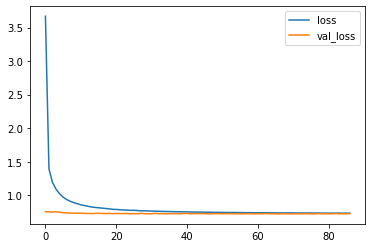

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [44]:
# history_df

<AxesSubplot:>

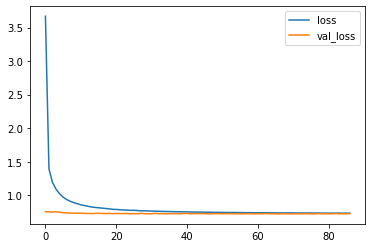

In [24]:
history_df.loc[:, ['loss', 'val_loss']].plot()
# history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [25]:
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_loss'].max()))

Best Validation Loss: 0.7215
Best Validation Accuracy: 0.7556


---
## write document
#--------------------------------------------
+ model of Adam:

`Best Validation Loss: 0.7128`

`Best Validation Accuracy: 0.8156`

+ model of SGD

`Best Validation Loss: 0.7201`

`Best Validation Accuracy: 0.9083`

`Best Validation Loss: 0.7215`

`Best Validation Accuracy: 0.7556`

In [22]:
out1 = model.predict(test)

In [23]:
out1


array([[7.5880985],
       [7.793169 ],
       [7.669372 ],
       ...,
       [7.258859 ],
       [7.5978856],
       [7.4901047]], dtype=float32)

In [29]:
submission = pd.read_csv("./tabular-playground-series-feb-2021/sample_submission.csv")

In [31]:
submission['target'] = out1


In [33]:
submission.to_csv('submission_1.csv', index=False)


In [27]:

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

2